In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [25]:
# Define the directory
directory = "datasets/"

# Load the sentences
sentences = pd.read_csv(directory + 'datasetSentences.txt', sep='\t')

# Load the dictionary
dictionary = pd.read_csv(directory + 'dictionary.txt', sep='|', names=['phrase', 'phrase_ids'])

# Load the sentiment labels
sentiments = pd.read_csv(directory + 'sentiment_labels.txt', sep='|')
sentiments.columns = ['phrase_ids', 'sentiment values']

# Merge the dictionary with the sentiments
dictionary = pd.merge(dictionary, sentiments, on='phrase_ids', how='inner')

In [26]:
def label_sentiment(row):
    if row['sentiment values'] < 0.510058:
        return 'negative'
    elif row['sentiment values'] < 0.526534:
        return 'neutral'
    else:
        return 'positive'


In [27]:
# Label sentiments for each phrase
dictionary['sentiment'] = dictionary.apply(label_sentiment, axis=1)

# Load the splits
splits = pd.read_csv(directory + 'datasetSplit.txt', sep=',')
splits.columns = ['sentence_index', 'splitset_label']
#print(splits)

In [28]:
# Merge the sentences DataFrame with the dictionary DataFrame on phrase/sentence
final_data = pd.merge(sentences, dictionary, left_on='sentence', right_on='phrase', how='inner')

# Then merge the final_data DataFrame with the splits DataFrame
final_data = pd.merge(final_data, splits, on='sentence_index', how='inner')

# Print the data with sentiment labels
print(final_data.head())

   sentence_index                                           sentence  \
0               1  The Rock is destined to be the 21st Century 's...   
1               2  The gorgeously elaborate continuation of `` Th...   
2               3                     Effective but too-tepid biopic   
3               4  If you sometimes like to go to the movies to h...   
4               5  Emerges as something rare , an issue movie tha...   

                                              phrase  phrase_ids  \
0  The Rock is destined to be the 21st Century 's...      226166   
1  The gorgeously elaborate continuation of `` Th...      226300   
2                     Effective but too-tepid biopic       13995   
3  If you sometimes like to go to the movies to h...       14123   
4  Emerges as something rare , an issue movie tha...       13999   

   sentiment values sentiment  splitset_label  
0           0.69444  positive               1  
1           0.83333  positive               1  
2           0.

In [29]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(final_data['sentence'])

In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, final_data['sentiment'], test_size=0.2, random_state=42)

# Train the SVM model with class_weight='balanced'
clf = svm.SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [31]:
# Evaluate the model
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.73      0.77      0.75      1083
     neutral       0.00      0.00      0.00        27
    positive       0.77      0.74      0.76      1148

    accuracy                           0.75      2258
   macro avg       0.50      0.50      0.50      2258
weighted avg       0.74      0.75      0.74      2258



In [32]:
# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[830   1 252]
 [ 18   0   9]
 [290   3 855]]


In [52]:
# Use the trained model to predict sentiment of new texts
conversation = [
    "Did it hurt?",
    "Did what hurt?",
    "When you fell from Heaven",
    "That pickup line has been done to death",
    "Oh, you got me! I promise, no more cheesy pickup lines if I can buy you a beer tonight?",
    "Where at?",
    "Harry's is awesome. I know the bartender and she makes some killer cocktails!",
    "Harry's it is",
    "Pick me up at 9?",
    "You bet, see you at 9 :)",
    ":D",
    "I love you",
    "I love you",
]

In [53]:
# Transform sentences to vectors
conversation_vectors = vectorizer.transform(conversation)

# Predict sentiments
predictions = clf.predict(conversation_vectors)

# Map predictions to numerical values
sentiment_mapping = {"negative": -1, "neutral": 0, "positive": 1}
numerical_predictions = [sentiment_mapping[pred] for pred in predictions]

# Define weights for the sentences: higher weight for recent sentences
weights = np.arange(1, len(numerical_predictions) + 1)

# Normalize the weights
weights = weights / np.sum(weights)

# Calculate the weighted mean sentiment
mean_sentiment = np.average(numerical_predictions, weights=weights)

In [54]:
# Assign overall sentiment based on the mean
if mean_sentiment < -2/3:
    overall_sentiment = "negative"
elif mean_sentiment < 1/3:
    overall_sentiment = "neutral"
else:
    overall_sentiment = "positive"

print("The overall sentiment of the conversation is:", overall_sentiment)


The overall sentiment of the conversation is: neutral


In [55]:
# Print the individual sentiment of each line along with the weight
for i in range(len(conversation)):
    print(f"Sentence: {conversation[i]}")
    print(f"Sentiment: {predictions[i]}")
    print(f"Weight: {weights[i]}")
    print()


Sentence: Did it hurt?
Sentiment: negative
Weight: 0.01098901098901099

Sentence: Did what hurt?
Sentiment: negative
Weight: 0.02197802197802198

Sentence: When you fell from Heaven
Sentiment: positive
Weight: 0.03296703296703297

Sentence: That pickup line has been done to death
Sentiment: negative
Weight: 0.04395604395604396

Sentence: Oh, you got me! I promise, no more cheesy pickup lines if I can buy you a beer tonight?
Sentiment: negative
Weight: 0.054945054945054944

Sentence: Where at?
Sentiment: negative
Weight: 0.06593406593406594

Sentence: Harry's is awesome. I know the bartender and she makes some killer cocktails!
Sentiment: positive
Weight: 0.07692307692307693

Sentence: Harry's it is
Sentiment: negative
Weight: 0.08791208791208792

Sentence: Pick me up at 9?
Sentiment: negative
Weight: 0.0989010989010989

Sentence: You bet, see you at 9 :)
Sentiment: positive
Weight: 0.10989010989010989

Sentence: :D
Sentiment: negative
Weight: 0.12087912087912088

Sentence: I love you
S

In [56]:
# Count the occurrences of each sentiment and weight them
sentiment_counts = Counter({sentiment: numerical_predictions.count(sentiment_mapping[sentiment]) * weight for sentiment, weight in zip(predictions, weights)})


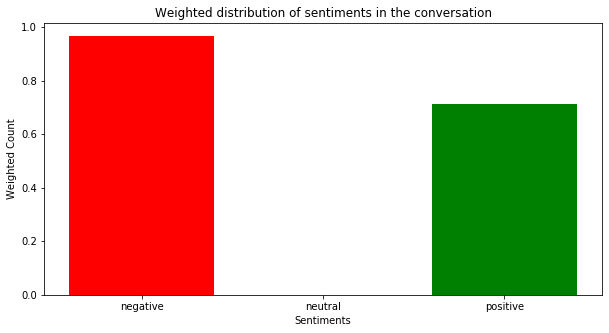

In [57]:
# Create a bar plot for the sentiment counts
plt.figure(figsize=(10, 5))
sentiments = ["negative", "neutral", "positive"]
counts = [sentiment_counts.get(sentiment, 0) for sentiment in sentiments]
colors = ['red', 'grey', 'green']
plt.bar(sentiments, counts, color=colors)
plt.xlabel('Sentiments')
plt.ylabel('Weighted Count')
plt.title('Weighted distribution of sentiments in the conversation')
plt.show()


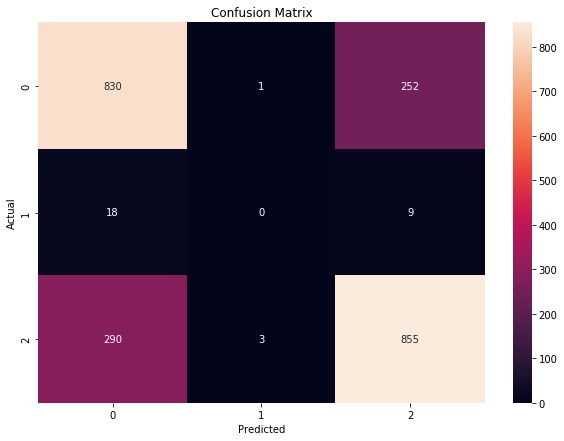

In [58]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()